In [1]:
#import tensorflow as tf
import datetime
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
import os, shutil
#from PIL import Image, ImageDraw, ImageFont, ImageColor
import random 
import pandas as pd
#from sklearn.multioutput import RegressorChain
 

In [2]:
train_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_15' 
# test_dataset_dir='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Testing_set_6_16' 

df=pd.read_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"))
df = df.sample(frac=1,random_state=5).reset_index(drop=True)

# dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
# dft = dft.sample(frac=1,random_state=5).reset_index(drop=True)

In [3]:
df.shape
#dft.shape 

(60750, 9)

In [5]:
def build_model():
    model = models.Sequential()                                  
    model.add(layers.Conv2D(32, (3,3) ,activation='relu', input_shape=(32,32,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8))
    return model

In [6]:
#Creates generators for training and validation images
SEED=5
validation_split_frac=0.2
batch_size=256
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split_frac)
test_datagen = ImageDataGenerator(rescale=1./255)  
train_generator= train_datagen.flow_from_dataframe(
        df,
        directory=train_dataset_dir,
        x_col="filename",
        y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
        target_size=(32,32),
        shuffle=True,
        color_mode='grayscale',
        seed= SEED,
        class_mode="raw",
        batch_size=batch_size,
        subset='training')

validation_generator= train_datagen.flow_from_dataframe(
        df,
        directory=train_dataset_dir,
        x_col="filename",
        y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
        target_size=(32,32),
        shuffle=True,
        color_mode='grayscale',
        seed= SEED,
        class_mode="raw",
        batch_size=batch_size,
        subset='validation')

# test_generator= test_datagen.flow_from_dataframe(
#         dft,
#         directory=test_dataset_dir,
#         x_col="filename",
#         y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
#         target_size=(32,32),
#         shuffle=True,
#         seed= SEED,
#         class_mode="raw",
#         batch_size=batch_size)

Found 97200 validated image filenames.
Found 24300 validated image filenames.


In [11]:
model=build_model()
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
num_epochs=100
training_steps=int(df.shape[0]*(1-validation_split_frac)/batch_size)
validation_steps=int(df.shape[0]*validation_split_frac/batch_size)
#assert (training_steps+validation_steps)*batch_size == df.shape[0]
# log_dir = os.path.join("Training_logs\\fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callback = callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True)
#my_callbacks=[ 
#    callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True),
#    callbacks.ModelCheckpoint(filepath="Model_Checkpoints",monitor="val_loss",save_best_only=True)
#]
history=model.fit(
    train_generator,
    steps_per_epoch=training_steps,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    verbose=1,
    callbacks=[callback]
    )

model_name='100erun6_18_grayscale'
model.save(os.path.join('Models',model_name))
hist_df = pd.DataFrame(history.history) 
hist_csv_file = os.path.join('Model_histories',model_name + '_history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 379 steps, validate for 94 steps
Epoch 1/50
379/379 [==============================] - 49s 130ms/step - loss: 0.1189 - mse: 0.0152 - mae: 0.0909 - val_loss: 0.0836 - val_mse: 0.0070 - val_mae: 0.0538
Epoch 2/50
379/379 [==============================] - 47s 124ms/step - loss: 0.0826 - mse: 0.0068 - mae: 0.0520 - val_loss: 0.0723 - val_mse: 0.0052 - val_mae: 0.0424
Epoch 3/50
379/379 [==============================] - 46s 122ms/step - loss: 0.0750 - mse: 0.0057 - mae: 0.0442 - val_loss: 0.0683 - val_mse: 0.0047 - val_mae: 0.0380
Epoch 4/50
379/379 [==============================] - 46s 122ms/step - loss: 0.0711 - mse: 0.0051 - mae: 0.0402 - val_loss: 0.0673 - val_mse: 0.0046 - val_mae: 0.0371
Epoch 5/50
379/379 [==============================] - 46s 122ms/step - loss: 0.0687 - mse: 0.0047 - mae: 0.0379 - val_loss: 0.0634 - val_mse: 0.0040 - val_mae: 0.0331
Epoch 6/50
379/379 [==============================] - 46s 122ms/step - l

In [5]:
model_name='100erun6_17_halfset'
#model=models.load_model(os.path.join('Models',model_name))
history_dict=pd.read_csv(os.path.join('Model_histories',model_name + '_history.csv'))

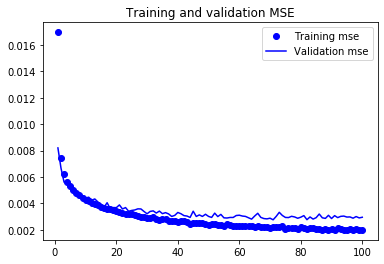

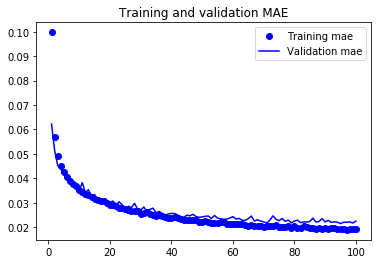

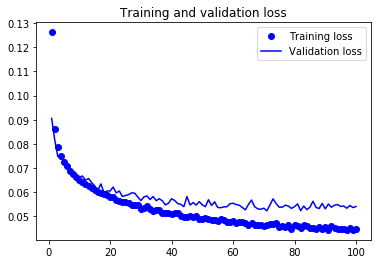

In [6]:
mse = history_dict['mse']
val_mse = history_dict['val_mse']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(mse) + 1)
plot_dir='History_Plots'

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation MSE')
plt.legend()
#plt.savefig(os.path.join(plot_dir,model_name+" mse.png"))
plt.figure()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation MAE')
plt.legend()
#plt.savefig(os.path.join(plot_dir,model_name+" mae.png"))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig(os.path.join(plot_dir,model_name+" loss.png"))

plt.show()

In [22]:
#Evaluates the model on testing set
testing_steps=dft.shape[0]//batch_size
log_dir = os.path.join("Training_logs\\test", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
model.evaluate(
    test_generator,
    steps=testing_steps
    #callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
42/42 [==============================] - 4s 91ms/step - loss: 0.0112 - mae: 0.0784


[0.011231104200262399, 0.078366056]

On the scale of two dimensional materials, stretching or straining the atomic lattice can have an enormous impact on the material properties of whatever you're working with. We can take photos of these materials with atomic resoution, however, the exact distribution of these atoms is hard to characterize by eye, and small strain of 1-2% is almost impossible to distinguish at first glance. My project is to design a machine learning model that can automaticaly detect the strain of a honeycomb lattice, even when that strain is small and varrying across an image. This would allow researchers to compare the strain of a material to its electronic properties and other observables, unveiling connections we haven't been able to see before. Many 2D materials are poorly understood, and this project could help answer many questions about how 2D phenomenon arise.